In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt


%matplotlib inline

warnings.filterwarnings('ignore')
pd.set_option('max_columns', 200)

# Inflation rate

In [2]:
inflation_rate = pd.read_excel('inflation_rate_1.xlsx')

inflation_rate.columns = ['date', 'rate', 'inflation', 'target']
inflation_rate.loc[:, "date"] = inflation_rate.date.astype(str)
inflation_rate.loc[:, "date"] = inflation_rate.date.str.replace('202', '2020').str.replace('20201', '2021').str.replace('20202', '2022')
inflation_rate.loc[:, "date"] = '01-' + inflation_rate.date.str.replace('.', '-')

inflation_rate.loc[:, "date"] = pd.to_datetime(inflation_rate.date, format="%d-%m-%Y")
inflation_rate.loc[:, "date"] = inflation_rate.date.dt.to_period('Q')

inflation_rate = inflation_rate.drop_duplicates(subset=['date', 'rate']).drop_duplicates(subset='date').drop('target', 1)

# Urals Oil Price

In [3]:
urals = pd.read_csv('urals.csv')

urals.columns = ['date', 'price', 'open', 'maxi', 'mini', 'volume', 'diff']
urals.date = pd.date_range(start='2011-01-01', end='2022-05-01', freq='m')[::-1]
urals = urals[['date', 'price']]
urals.loc[:, "date"] = urals.date.dt.to_period('Q')
urals = urals.drop_duplicates(subset='date')

df = pd.merge(urals, inflation_rate, on='date', how='inner')

# Budget

In [4]:
budget = pd.read_csv('budget.csv')
budget = budget.astype(str)
budget.columns = ['field'] + pd.date_range("01/01/2011", "31/12/2021", freq='Q').tolist()

budget = budget.T
budget.columns = budget.loc['field', :]
budget = budget.iloc[1:]

budget.index = pd.to_datetime(budget.index)
budget.index = budget.index.to_period('Q')
budget.columns = budget.columns.values
budget['date'] = budget.index.values

# Preprocessing

In [5]:
df = pd.merge(df, budget, on='date', how='inner')

df.price = df.price.str.replace(',', '.')
df.price = df.price.astype(float)

df = df.rename(columns={
    'Доходы, всего': 'total_income',
    'Нефтегазовые доходы': 'oil_income',
    'Ненефтегазовые доходы': 'non_oil_income',
    'Расходы, всего': 'total_spending',
    'Общегосударственные вопросы': "state_questions",
    'Национальная оборона': "nat_defence",
    'Национальная безопасность и правоохранительная деятельность': "nat_security",
    'Национальная экономика': "nat_economy",
    'Жилищно-коммунальное хозяйство': "house_service",
    'Охрана окружающей среды': "environment",
    'Образование': "education",
    'Культура, кинематография': "culture",
    'Здравоохранение': "health",
    'Социальная политика': "social_policy",
    'Физическая культура и спорт': "sport",
    'Средства массовой информации': "media",
    'Обслуживание государственного и муниципального долга': "public_debt",
    'Межбюджетные трансферты общего характера бюджетам бюджетной системы Российской Федерации': "transfrets"
})

for col in df.columns:
    try:
        df.loc[:, col] = df[col].str.replace(' ', '').str.replace(',', '')
        df.loc[:, col] = df[col].astype(float)
    except Exception as er:
        print(er)

Can only use .str accessor with string values!
Can only use .str accessor with string values!
Can only use .str accessor with string values!
Can only use .str accessor with string values!


# Gross Domestic Product

In [6]:
# в ценах 2016 года
real_gdp = pd.read_csv('gdp_real.csv')
real_gdp = real_gdp.T
real_gdp['date'] = pd.date_range("01/01/2011", "31/12/2021", freq='Q').tolist()
real_gdp.reset_index(inplace=True)
real_gdp.columns = ['gdp_real', 'date']
real_gdp['gdp_real'] = real_gdp['gdp_real'].str.replace(',', '').astype(float)
real_gdp['date'] = real_gdp.date.dt.to_period('Q')

df = pd.merge(df, real_gdp, on='date', how='inner')

df = df.sort_values(by='date', ascending=True)
df.index = np.arange(len(df))
df['gdp_dynamic'] = df['gdp_real'].diff().fillna(0) / df['gdp_real']

# Deflator

In [7]:
deflator = pd.read_csv('deflator.csv')
deflator = deflator.T
deflator.reset_index(inplace=True)

deflator.columns = ['date', 'deflator']
deflator.date = pd.to_datetime(deflator.date, format='%d.%m.%Y')
deflator.date = deflator.date.dt.to_period('Q')
df = pd.merge(df, deflator, on='date', how='inner')

# Original budget values from cumsum

In [8]:
for i in range(2, len(df), 4):
    for col in df.drop(['date', 'price', 'rate', 'inflation', 'gdp_real', 'gdp_dynamic', 'deflator'], 1).columns:
        df.loc[i: i+3, col] = df.loc[i: i+3, col].diff().fillna(df.loc[i: i+3, col])

for col in df.drop(['date', 'price', 'rate', 'inflation', 'gdp_real', 'gdp_dynamic', 'deflator'], 1).columns:
    df.loc[1, col] = df.loc[1, col] - df.loc[0, col]
    
    
for col in df.drop(['date', 'price', 'rate', 'inflation', 'gdp_real', 'gdp_dynamic', 'deflator'], 1).columns:
    df.loc[:, col] = df.loc[:, col] * (df['deflator'] / 100)

# Final dataset

In [9]:
df_final = df[[
    'date', 'price', 'rate', 'inflation',
    'oil_income', 'total_income',
    'nat_defence', 'nat_security', 'house_service', 'education', 'health',
    'gdp_dynamic', 'gdp_real'
]]
df_final.index = df.date

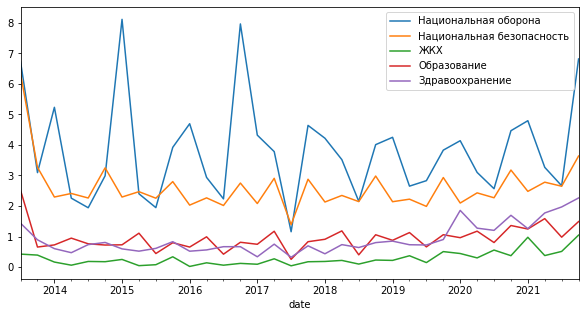

In [10]:
plt.figure(figsize=(10, 5))
(100 * df_final['nat_defence'] / df_final['gdp_real']).plot(legend='best')
(100 * df_final['nat_security'] / df_final['gdp_real']).plot()
(100 * df_final['house_service'] / df_final['gdp_real']).plot()
(100 * df_final['education'] / df_final['gdp_real']).plot()
(100 * df_final['health'] / df_final['gdp_real']).plot()
plt.legend(["Национальная оборона", "Национальная безопасность", "ЖКХ", "Образование", "Здравоохранение"])
plt.savefig('spends.png')
plt.show()

In [11]:
df.to_csv('data_gmu.csv')

In [12]:
from statsmodels.tsa.api import VAR, SVAR
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [13]:
df_final['taxes_income'] = df_final['total_income'] - df_final['oil_income']

endog = ['gdp_real', 'nat_defence', 'nat_security', 'house_service', 'education', 'health', 'taxes_income']
endog_log = ['gdp_real', 'nat_defence', 'nat_security', 'house_service', 'education', 'health', 'taxes_income']
exog = ['price', 'rate', 'oil_income']
exog_log = ['price', 'oil_income']

In [14]:
df_final[endog_log + exog_log] = np.log(df_final[endog_log + exog_log])

In [15]:
df_final.to_csv('data_gmu.csv')

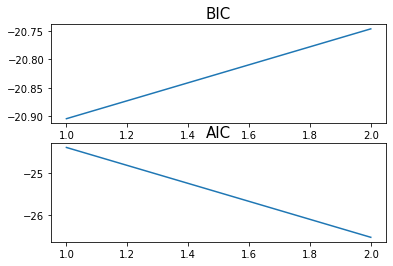

<Figure size 720x720 with 0 Axes>

In [17]:
bic = []
aic = []
lags = list(range(1, 3))
for lag in lags:
    model = VAR(endog=df_final[endog], exog=df_final[exog]).fit(lag)
    bic.append(model.bic)
    aic.append(model.aic)
    
fig, ax = plt.subplots(nrows=2, ncols=1);
plt.figure(figsize=(10, 10));
ax[0].set_title('BIC', fontsize=15)
ax[0].plot(lags, bic);
ax[1].set_title('AIC', fontsize=15)
ax[1].plot(lags, aic);

In [18]:
print(aic)

[-24.396376747043753, -26.518041435441333]


In [19]:
model = VAR(endog=df_final[endog], exog=df_final[exog])
a = model.select_order(2)
a.selected_orders

{'aic': 2, 'bic': 1, 'hqic': 2, 'fpe': 2}

In [20]:
model = VAR(endog=df_final[endog], exog=df_final[exog]).fit(2)
print(model.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 19, Apr, 2022
Time:                     20:59:34
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -20.7467
Nobs:                     32.0000    HQIC:                  -24.6050
Log likelihood:           232.446    FPE:                8.57404e-12
AIC:                     -26.5180    Det(Omega_mle):     3.77090e-13
--------------------------------------------------------------------
Results for equation gdp_real
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                   16.369164         2.805876            5.834           0.000
price                   -0.022468         0.030790           -0.730           0.466
rate                    -0.000545         0.0

In [40]:
feature_causing_gdp = model.test_causality(caused='nat_defence', causing='gdp_real', kind='f')
print(feature_causing_gdp.h0)
print(feature_causing_gdp.conclusion)

H_0: gdp_real does not Granger-cause nat_defence
reject


In [38]:
feature_causing_gdp.crit_value

3.0892030130201875

In [55]:
feature_causing_gdp.pvalue

0.967463696556889

In [52]:
feature_causing_gdp = model.test_causality(caused='education', causing='gdp_real', kind='f')
print(feature_causing_gdp.h0)
print(feature_causing_gdp.conclusion)

H_0: gdp_real does not Granger-cause education
fail to reject


In [54]:
feature_causing_gdp = model.test_causality(caused='health', causing='gdp_real', kind='f')
print(feature_causing_gdp.h0)
print(feature_causing_gdp.conclusion)

H_0: gdp_real does not Granger-cause health
fail to reject


In [48]:
feature_causing_gdp = model.test_causality(caused='nat_security', causing='gdp_real', kind='f')
print(feature_causing_gdp.h0)
print(feature_causing_gdp.conclusion)

H_0: gdp_real does not Granger-cause nat_security
fail to reject


In [50]:
feature_causing_gdp = model.test_causality(caused='house_service', causing='gdp_real', kind='f')
print(feature_causing_gdp.h0)
print(feature_causing_gdp.conclusion)

H_0: gdp_real does not Granger-cause house_service
reject
